In [1]:
# Importing libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

import torch
from torch import Tensor
from torch.utils.data import DataLoader
from torch import nn, optim
from torch.autograd.variable import Variable
from torchvision import transforms, datasets
import torch.nn.functional as Func

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import sys
import random
import os
import tqdm
import glob

from functions.functions_for_dataload import *
from functions.fnc import *

######### Generating new samples ###########
from datetime import date
from datetime import datetime

from openpyxl import load_workbook
import seaborn as sns; sns.set(color_codes=True)

today = date.today()
%matplotlib inline  

In [2]:
# Loading Data
numOfBuses = 14
numOfLines = 20
attacked_Bus = 5

num_Of_attacked_buses = attacked_Bus

noise_dimension = numOfBuses
z_dim = noise_dimension
numOfZ = numOfBuses + 2* numOfLines
numOfStates = numOfBuses

In [3]:
file_name = f"Bus Data\\IEEE_{numOfBuses}.xlsx"

# Load data into Dataframes
bus_data_df = pd.read_excel (file_name, sheet_name = "Bus")
line_data_df = pd.read_excel (file_name, sheet_name = "Branch")
# update the index from 1 to number of elements
bus_data_df.set_index(pd.Series(range(1, numOfBuses+1)), inplace = True)
line_data_df.set_index(pd.Series(range(1, numOfLines+1)), inplace = True)

# number of lines and measurements
numOfLines = line_data_df.shape[0]
numOfZ = numOfBuses + numOfLines * 2
W_list = (numOfZ + 1)*[1]

############################################################
# Loading Topology Data and Measurement Data
try:
    topo_mat = pd.read_excel(file_name, sheet_name = "Topology Matrix")
    line_data  = pd.read_excel(file_name, sheet_name = "Line Data")
    print("Topology Matrix Loaded!")
except:
    print("Generating Topology Matrix...")
    topo_mat, line_data = generate_topology_matrix(numOfBuses, numOfLines, line_data_df, file_name)

Topo = line_data.values.astype(int) #Another name
###############################################################
# Loading Topology Data and Measurement Data
try:
    Z_msr_org = pd.read_excel(file_name, sheet_name = "Measurement Data")
    bus_data = pd.read_excel(file_name, sheet_name = "Bus Data")
    print("Measurement Data Loaded!")
except:
    print("Generating Measurement Data...")
    Z_msr_org, bus_data = generate_Z_msr_org(numOfBuses, numOfLines, bus_data_df, topo_mat, file_name)

# Adding IDs and Reported columns
Z_msr_org.insert(0, 'ID', list(Z_msr_org.index.values))
Z_msr_org.insert(1, 'Reported', [1]* (numOfZ+1))
###############################################################
#************  reading network topo data **************
fnetname = f'Bus Data//Net_Topo_{numOfBuses}.txt'
try: netdata = open(fnetname).readlines() 
except: 
    print("File Does not exist!")
################################################################

# Load Attack Data, otherwise generate attack data

Topology Matrix Loaded!
Measurement Data Loaded!


In [4]:
# generate_others

In [5]:
def generate_others(numOfBuses, numOfLines, num_Of_attacked_buses, data, Topo):
    data = pd.DataFrame(data)
    numOfZ = numOfBuses + 2* numOfLines
    num_Of_attack = int (data.shape[0]/numOfZ)
    # Preprocessing data

    false_Data = pd.DataFrame([])
    combination_Data_Sensor = pd.DataFrame([])
    combination_Data_Cluster = pd.DataFrame([])

    start_indx = 0
    end_indx = start_indx + numOfZ + 1

    progress = tqdm.tqdm(total=num_Of_attack, desc='Done', position=0)
    while (end_indx <= data.shape[0]):
        progress.update(1)
        attack_data = data.iloc[start_indx + 1 : end_indx, 2]
        combination_data = data.iloc[start_indx + 1 : end_indx, 1].astype(int)

        sensor_ids = np.where(combination_data.values == 1)[0]+1
        if len(sensor_ids) > 0:        
            cluster_maping,_ =  assignClusterID (sensor_ids, Topo, NumOfBuses=numOfBuses, NumOfLines = numOfLines)
            combination_Data_Cluster = combination_Data_Cluster.append(pd.DataFrame(cluster_maping, index = None, columns = None).T)

            false_Data = false_Data.append(pd.DataFrame(attack_data.values, index = None, columns = None).T)
            combination_Data_Sensor = combination_Data_Sensor.append(pd.DataFrame(combination_data.values, index = None, columns = None).T)

        start_indx += numOfZ+1
        end_indx = start_indx + numOfZ + 1
        #print(start_indx, end_indx)
    false_Data.index = range(1, false_Data.shape[0]+1)
    false_Data.columns = range(1, false_Data.shape[1]+1)
    combination_Data_Sensor.index = range(1, combination_Data_Sensor.shape[0]+1)
    combination_Data_Sensor.columns = range(1, combination_Data_Sensor.shape[1]+1)

    combination_Data_Cluster.index = range(1, combination_Data_Cluster.shape[0]+1)
    combination_Data_Cluster.columns = range(1, combination_Data_Cluster.shape[1]+1)


    false_Data.to_excel(f'Attack Data//false_Data_{numOfBuses}_{numOfLines}_{num_Of_attacked_buses}.xlsx', engine='xlsxwriter', index = True) 
    combination_Data_Sensor.to_excel(f'Attack Data//combination_Data_Sensor_{numOfBuses}_{numOfLines}_{num_Of_attacked_buses}.xlsx', engine='xlsxwriter', index = True) 
    combination_Data_Cluster.to_excel(f'Attack Data//combination_Data_Cluster_{numOfBuses}_{numOfLines}_{num_Of_attacked_buses}.xlsx', engine='xlsxwriter', index = True) 
    return false_Data, combination_Data_Sensor, combination_Data_Cluster

In [6]:
# Load Attack Data, otherwise generate attack data

try:
    file_Name_ = "Attack_Space_"+str(numOfBuses)+"_"+str(numOfLines)+"_"+str(attacked_Bus)+".csv"
    Attack_Data = np.genfromtxt("Attack Data//"+file_Name_, delimiter=',')
    print("Attack data loaded!")
    file_name = f"IEEE_{numOfBuses}.xlsx"
    false_Data = pd.read_excel(f'Attack Data//false_Data_{numOfBuses}_{numOfLines}_{attacked_Bus}.xlsx', index_col=0)
    combination_Data_Sensor = pd.read_excel(f'Attack Data//combination_Data_Sensor_{numOfBuses}_{numOfLines}_{num_Of_attacked_buses}.xlsx', index_col=0)
    combination_Data_Cluster = pd.read_excel(f'Attack Data//combination_Data_Cluster_{numOfBuses}_{numOfLines}_{num_Of_attacked_buses}.xlsx', index_col=0)
    # combination_Data = pd.read_excel(f'Attack Data//combination_Data_{numOfBuses}_{numOfLines}_{attacked_Bus}.xlsx', index_col=0)

except:
    print("Attack Data is missing! Generating attack data!")
    current_path = os.getcwd()
    Attack_Data = generate_attackdata(numOfBuses, numOfLines, line_data, attacked_Bus, current_path)
    
    false_Data, combination_Data_Sensor, combination_Data_Cluster = generate_others(
        numOfBuses, numOfLines, attacked_Bus, Attack_Data, Topo)
    
numOfAttacks = int (Attack_Data.shape[0]/(numOfZ+1))
print("numOfAttacks: ", numOfAttacks)

Attack data loaded!
numOfAttacks:  129


In [7]:
combination_Data = combination_Data_Sensor.copy()

test_size = 0.25
# Scaling the data
stdscaler = StandardScaler()
X_org = stdscaler.fit_transform(false_Data) 

#splitting train and test data
false_Data_Train, false_Data_Test = train_test_split(false_Data, test_size = test_size, random_state=42)
X_Train, X_Test = train_test_split(X_org, test_size = test_size, random_state=42)

combination_Data_Train, combination_Data_Test =  train_test_split(combination_Data, test_size = test_size, random_state=42)

print("Split done!")
print("Total training data: ", false_Data_Train.shape[0])

data = [x_i for x_i in X_Train]
class Data_Loader():
    
    def __init__(self,data_list):       
        self.data=data_list

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        sample = self.data[index]
        sample_tensor = Tensor(sample).float()
#         label = self.data[index][1]
        return sample_tensor

dataSet=Data_Loader(data)
data_loader = DataLoader(dataset=dataSet, batch_size = 64, shuffle= True)
print("Data Loader Created!")

Split done!
Total training data:  96
Data Loader Created!


#### Model

In [8]:
Model = "WGAN_WC"
model_Train = True

In [9]:
if numOfBuses == 14:
    G_nodes = [z_dim, 20, 40, numOfZ]
    D_nodes = [numOfZ, 25, 10, 1]
    
elif numOfBuses == 30:
    G_nodes = [z_dim, 56, 80, numOfZ]
    D_nodes = [numOfZ, 64, 32, 1]

elif numOfBuses == 57:
    G_nodes = [z_dim, 80, 150, numOfZ]
    D_nodes = [numOfZ, 100, 50, 1]
    

In [10]:
if Model == 'WGAN_WC':
    # GeneratorNet
    G = torch.nn.Sequential(
        nn.Linear(G_nodes[0], G_nodes[1]),
        nn.ReLU(True),
    #     nn.Dropout(0.10),

        nn.Linear(G_nodes[1], G_nodes[2]),
        nn.ReLU(True),
    #     nn.Dropout(0.10),
        nn.Linear(G_nodes[2], G_nodes[3])
    )

    # DiscriminatorNet
    D = torch.nn.Sequential(
        nn.Linear(D_nodes[0], D_nodes[1]),
        nn.ReLU(True),
    #     nn.Dropout(0.15),

        nn.Linear(D_nodes[1], D_nodes[2]),
        nn.ReLU(True),
    #     nn.Dropout(0.15),

        nn.Linear(D_nodes[2], D_nodes[3])
    #     nn.Sigmoid()
    )

    # reset_grad
    def reset_grad():
        G.zero_grad()
        D.zero_grad()

    def noise(size):
        n = Variable(torch.randn(size, z_dim))
        return n
    
    def train_discriminator(optimizer, real_data, fake_data):
        
        # predict on the real and fake data
        D_real = D(real_data)
        D_fake = D(fake_data)
        
        # Calculate loss
        D_loss = -(torch.mean(D_real) - torch.mean(D_fake))

        D_loss.backward()
        optimizer.step()

        #Weight clipping
        for p in D.parameters():
            p.data.clamp_(-0.01, 0.01)
#             #reset gradient
        reset_grad()
        # Return error and predictions for real and fake inputs
        return D_loss

    def train_generator(optimizer, fake_data):
        # Reset gradients
#         reset_grad()
        # Sample noise and generate fake data
        D_fake = D(fake_data)
        # Calculate error and backpropagate
        G_loss = -torch.mean(D_fake)
        G_loss.backward()
        # Update weights with gradients
        optimizer.step()
        # Return error
        reset_grad()
        return G_loss

In [11]:
def train_harmonizer(optimizer, sample):
    sample = stdscaler.inverse_transform(sample.data)
    sample = torch.from_numpy(sample).float()
    sample_est = H_tensor@(torch.pinverse(H_tensor.T@H_tensor)@H_tensor.T)@sample.reshape(numOfZ,1).flatten()
    #sample = torch.from_numpy(sample.flatten())
    sample =sample.flatten()

    sample = Variable(sample.data, requires_grad=True)
    sample_est = Variable(sample_est.data, requires_grad=True)
    G_loss_MSE = alpha * MSE_loss(sample_est, sample)
    G_loss_MSE.backward()
    optimizer.step()
    #reset gradient
#     reset_grad()
    optimizer.zero_grad()
    return G_loss_MSE

def noise(size):
    '''
    Generates a 1-d vector of gaussian sampled random values
    '''
    n = Variable(torch.randn(size, noise_dimension))
    return n

In [ ]:
# false_Data_Test.hist()
def plot_corr():
    
    test_samples = 1000
    false_data_dist = stdscaler.inverse_transform(G(noise(test_samples)).detach().numpy())
    false_data_dist = pd.DataFrame(false_data_dist, columns = range(1,numOfZ+1), index = range(1,test_samples+1))
    fig, ax = plt.subplots(figsize=(5,4))         
    sns.heatmap(false_data_dist.corr(), annot=False, linewidths=0, ax=ax, center = 0, square = True)
    plt.tight_layout()
    #plt.savefig(f'Evaluation//'+Model+f'//{numOfBuses}//{Model}_Heat_Map_{epoch}.jpg', dpi = 250)
    os.makedirs(f'Evaluation//'+Model+f'//{numOfBuses}//', exist_ok=True)
    plt.savefig(f'Evaluation//'+Model+f'//{numOfBuses}//{Model}_Heat_Map_{epoch}.jpg', dpi = 250)
    plt.show()


def eval_model():
    print("epoch: ", epoch,'\n\n')
    ######
    # Ploting the laerning curve
    plt.close()
    plt.figure(0)
    plt.plot(d_errs, color = 'r')
    plt.plot(g_errs, color = 'g')
    plt.show()
    # plotting correlation
    plot_corr()
    
def save_model():
    
    time = str(datetime.now()).split(".")[0]
    time = time.replace(":","-")

    torch.save(G, f'Models//'+Model+f'//{numOfBuses}//{Model}_{attacked_Bus}_{cond_type}_generator_{epoch}_'+ str(time) + ".pb")
    torch.save(D, f'Models//'+Model+f'//{numOfBuses}//{Model}_{attacked_Bus}_{cond_type}_discriminator_{epoch}_'+ str(time) + ".pb")

    #Saving the learning curve
    plt.figure(0)
    plt.plot(d_errs, color = 'r', label= 'd_errs')
    plt.plot(g_errs, color = 'g', label= 'g_errs')
    plt.xlabel("Number of epoch")
    plt.ylabel("Loss")
    plt.title(f"Training curve of {Model}")
    plt.legend()
    plt.savefig(f'Models//'+Model+f'//{numOfBuses}//{Model}_{attacked_Bus}_{cond_type}_Learning_Curve_{epoch}_' + str(time) +'.pdf')
    plt.show()

In [13]:
##########################    Copying the original Data ###########################
print('Checking State Estimation and Bad Data Detector on clean data') 
H_org = topo_mat.values.copy() 
Z_org = Z_msr_org.values.copy()
Z_mat = Z_org.copy()
Threshold_min = 2
Threshold_max = 2
W_list = (numOfZ + 1)*[1]
##################################################################################
# Running the State Estimation and Bad Data Detection Algorithm on actual data
States_init, Z_est_init, Z_mat_init, M_Noise_actu, Noisy_index_actu, fullRank, Threshold = SE_BDD_(
    H_org.copy(), Z_org.copy(), W_list, Threshold_min, Threshold_max, Verbose = "False")
if Noisy_index_actu.size == 0:
    print("Working fine!")
else: print("Got some issue!!!!!!")
    
H_tensor = torch.from_numpy(H_org[1:,:]).float()

Checking State Estimation and Bad Data Detector on clean data
Working fine!


Epoch:   0%|          | 0/25000 [00:00<?, ?it/s]

epoch:  0 




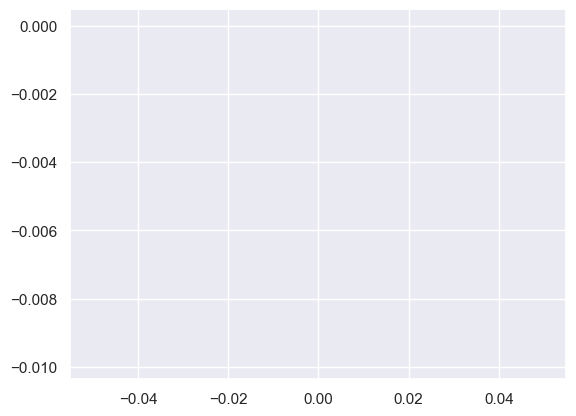

FileNotFoundError: [Errno 2] No such file or directory: 'Evaluation//WGAN_WC//14//WGAN_WC_Heat_Map_0.jpg'

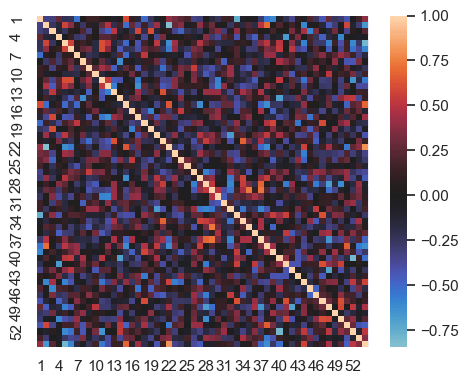

In [14]:
#Hyper parameters

cond_type  = 0

MSE_loss = nn.MSELoss()
num_epochs = 25000
epoch = num_epochs-1
lr = 5e-5
disRepaet = 5
max_harmonize = 64
# max_harmonize = 0
alpha = lr

#List to save the loss
g_errs = []
d_errs = []
mse_errs = []
loss = nn.BCELoss()
 
if Model == 'WGAN_WC' and model_Train == True:
    
    # Optimizer functions
    g_optimizer = optim.RMSprop(G.parameters(), lr = lr, momentum= 0.9)
    d_optimizer = optim.RMSprop(D.parameters(), lr = lr, momentum= 0.9)
    
    progress = tqdm.tqdm(total=num_epochs, desc='Epoch', position = 0)

    # starting the epoch
    for epoch in range(num_epochs):
        #print("Epoch: ", epoch)
        progress.update(1)

        # Starting Discriminator training
        for _ in range(disRepaet):
            # Sample data
            for n_batch, real_batch in enumerate(data_loader):
                N = real_batch.size(0)   
                real_data = Variable(real_batch)
                # Generate fake data and detach 
                fake_data = G(noise(N)).detach()
                # Train D
                D_loss = train_discriminator(d_optimizer, real_data, fake_data)
                #reset gradient


        # Starting Generator training
        for n_batch, real_batch in enumerate(data_loader):
            N = real_batch.size(0)   
            # Generate fake data
            fake_data = G(noise(N))
            # Train G
            G_loss = train_generator(g_optimizer, fake_data)

        #Starting harmonizer training
#         if epoch > 0 :
        for harmonize_repeat in range(max_harmonize):
            fake_data = G(noise(1))
            G_loss_MSE = train_harmonizer(g_optimizer, fake_data)
            mse_errs.append(G_loss_MSE.detach().cpu().numpy())       


        d_errs.append(D_loss.detach().cpu().numpy())
        g_errs.append(G_loss.detach().cpu().numpy())
        
        if (epoch) % 500 == 0:
            # show and eval model generating a single sample
            eval_model()
            save_model()
    ##################### Saving the model #######
    save_model()
    ####################################################



# # importing the latest models
else:
    Models_list = glob.glob(f'Models//'+Model+f'//{numOfBuses}//{Model}_{attacked_Bus}_{cond_type}_*_{epoch}_*.pb')
    try:
        Models_list.sort(reverse= True)
        latest_time = Models_list[0].split("_")[-1][0:-3]
        print("latest_time:", latest_time)
        print(f'Models//'+Model+f'//{numOfBuses}//{Model}_{attacked_Bus}_{cond_type}_generator_{epoch}_'+ str(latest_time) + ".pb")
        G = torch.load(f'Models//'+Model+f'//{numOfBuses}//{Model}_{attacked_Bus}_{cond_type}_generator_{epoch}_'+ str(latest_time) + ".pb")
        D = torch.load(f'Models//'+Model+f'//{numOfBuses}//{Model}_{attacked_Bus}_{cond_type}_discriminator_{epoch}_'+ str(latest_time) + ".pb")
        print("Model Loaded")
    except:
        print("Model not found!!!!")


In [ ]:
epoch = 'final'
test_samples = 10
false_data_dist = stdscaler.inverse_transform(G(noise(test_samples)).detach().numpy())
false_data_dist = pd.DataFrame(false_data_dist, columns = range(1,numOfZ+1), index = range(1,test_samples+1))
fig, ax = plt.subplots(figsize=(5,4))         
sns.heatmap(false_data_dist.corr(), annot=False, linewidths=0, ax=ax, center = 0, square = True)
plt.tight_layout()
plt.grid(True)
plt.savefig('Evaluation//'+Model+f'//{numOfBuses}//Heat_Map_{epoch}.jpg')
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(5,4))         
sns.heatmap(false_Data.corr(), annot=False, linewidths=0, ax=ax, center = 0, square = True)
plt.tight_layout()
plt.grid(False)
os.makedirs('Evaluation//'+Model+f'//{numOfBuses}//', exist_ok=True)
plt.savefig('Evaluation//'+Model+f'//{numOfBuses}//Training_Heat_Map.jpg', dpi = 250)
plt.show()

In [ ]:
# false_Data.corr()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.axes_style("whitegrid")

target_lines = numOfLines
selected_lines = range(1, numOfLines+1)
# print(selected_lines)

fig, axList = plt.subplots(nrows=2, ncols=10)

axList = axList.flatten()
fig.set_size_inches(36,8)

for ax, line in zip(axList, selected_lines):
    ax.scatter(false_data_dist[line].values,false_data_dist[line+numOfLines].values, alpha = 0.5,  s= 150, marker= 'p', label = 'Generated')
    ax.scatter(false_Data_Train[line].values,false_Data_Train[line+numOfLines].values, alpha = 0.5,  s= 150, marker= 'p', label = 'Training')

    ax.set_title(f"line: {line}")
    ax.set_aspect('equal')
ax.legend(fontsize= 20)  
# # Set common labels
fig.text(0.5, 0.02, 'Forward line power flow', ha='center', va='center',fontsize= 40)
fig.text(0.003, 0.5, 'Backward line power flow', ha='center', va='center', rotation='vertical', fontsize= 40)
fig.text(0.5, 0.98, 'Correlation between forward and backward line power flow', ha='center', va='center', fontsize= 40)
# fig.set_title("Forward and backward linepower flow")
plt.tight_layout()  
# plt.savefig(f'Evaluation//'+Model+'//Linewise_Corr.pdf')

plt.savefig('Evaluation//'+Model+f'//{numOfBuses}//Linewise_Corr.jpg', dpi = 300)

In [ ]:
sns.axes_style("whitegrid")
targets = random.sample(range(1,numOfZ), 5)

for target in targets:
    fig,ax = plt.subplots(figsize=(5,3.5))
    ax = sns.kdeplot(false_Data_Train[target], shade = True, color = 'b',   label = '$\mathcal{T}_{F}$')
    plt.legend(loc = 'upper left', fontsize = '13')
    plt.ylabel('Density (Traing)', fontsize = '15')
    plt.xlabel("Injection Amount", fontsize = '15')
    plt.xticks (fontsize = '13')
    plt.yticks (fontsize = '13')

    ax2=ax.twinx()
    ax2 = sns.kdeplot(false_data_dist[target], shade = True, color = 'r', linestyle = '--', label = '$\mathcal{T}_{G}$')
    plt.legend(loc = 'upper right', fontsize = '15')
    plt.xlabel("Values", fontsize = '15')
    plt.ylabel('Density (Generated)', fontsize = '15')
    plt.title(f'Distribution of Sensor : {target}', fontsize = '15')
    plt.grid(True)
    plt.xticks (fontsize = '13')
    plt.yticks (fontsize = '13')
    plt.tight_layout()
    os.makedirs('Evaluation//'+Model+f'//{numOfBuses}//', exist_ok=True)
    plt.savefig('Evaluation//'+Model+f'//{numOfBuses}//{Model}_sensor_dist_{target}.jpg', dpi = 350)
    plt.savefig('Evaluation//'+Model+f'//{numOfBuses}//{Model}_sensor_dist_{target}.pdf')

    plt.show()

### Generating more samples

In [ ]:
#################################################################################
def attack_estimate(H_mat, Z_mat):
    import numpy as np
    from numpy.random import seed
    from numpy.random import randn
    from numpy import mean
    from numpy import std
    
#     Z_mat = Z_mat[Z_mat[:,0].argsort(kind='mergesort')]
    #print("\n **************  State Estimation ************* \n")
    #takes H matrix Z measurements, Threshold and number of Equations as input
    #print("Considering only the taken measurements")
    
    Z_msr_init = Z_mat[Z_mat[:,1]==1][:,2]
    
    # considering only the corresponding columns in H   
    
    H_mat_init = H_mat[Z_mat[:,1]==1]

    #printing the sizes of H, Rank (H) and Z
    
    Rank = np.linalg.matrix_rank(H_mat_init)
    #print("Rank of Noisy: " , Rank)
    
    Z_est = np.zeros(H_mat.shape[0])
    
    if Rank == H_mat.shape[1]:
        
        fullRank = True
        # Estimating the states using WMSE estimator
        #States_init = np.linalg.pinv(H_mat_init)@Z_msr_init
        States_init = (np.linalg.inv(H_mat_init.T@H_mat_init)@H_mat_init.T)@Z_msr_init

        # Estimating the measurement from the estimated states
        Z_est = H_mat@States_init

    else:
        
        #print("The H is not a full rank matrix !!")
        fullRank = False
        States_init = 0
        #Z_est = 0
        P_Noise = 0
        
    return States_init, Z_est, fullRank
###############################################

In [ ]:
# ## Updated
# from sklearn.metrics import mean_squared_error

# from sklearn.metrics import mean_absolute_error

# Threshold_min = 2
# Threshold_max = 2

# # Generated images
# maxGen = 1000

# # Sdt factors
# std_factors = [0.00, 0.25, 0.50]

# max_est_list = [0, 1, 2, 3, 4, 5]

# run_harmonizer = True

# total_noisy_preds = []
# total_distance = []
# success_rates = []
# false_Data_Gen_list = []
# raw_Data_Gen_list = []
# combination_Data_Gen_list = []
# data_df_list = []
# noisy_preds = []
# # false_Data_Gen = pd.DataFrame([])
# # data_df=  pd.DataFrame([])
# distance = []
# # success = [0, 0, 0, 0, 0]
# # Generating new samples
# # progress = tqdm.tqdm(total=len(std_factors), desc='Generation: ', position = 0)

# # Generate more images
# test_imagess =(G(noise(maxGen)))
# #test_imagess = np.random.randn(maxGen, numOfZ)
# test_imagess = test_imagess.data
# samples = stdscaler.inverse_transform(test_imagess)
# false_Data_Gen_Est = []
# for max_est in max_est_list:
#     success = [0]*len(std_factors)
#     false_Data_Gen = pd.DataFrame([])
#     data_df=  pd.DataFrame([])
    
#     for index, sample_init in enumerate(samples):
#         #print("\n\nsample ID: ", index)

#         #print("Generating Sample:")
#         sample_zero = sample_init.copy()

#     #     if abs(sample_init).max()>500:
#     #         print("Too_much: scaling the attack vector")
#     #         sample_init = sample_init*500/abs(sample_init).max()
#     #     ############ Storing them as raw file ############


#          ###### save the  raw data #######
#         data_df[f'r_for_{index}'] = sample_init[0:20]
#         data_df[f'r_bac_{index}'] = sample_init[20:40]
#         data_df[f'r_bus_{index}'] = pd.Series(sample_init[40:].tolist())

#         # Saving the raw data
#         column_name = f'{index}_0'
#         sample_df = pd.DataFrame(sample_init.tolist(), index = range(1, numOfZ+1), columns = [column_name])
#         false_Data_Gen = false_Data_Gen.append(sample_df.T,  ignore_index = False)

#         ###########################
#         sample_mean = np.mean(sample_init)
#         sample_std = np.std(sample_init)
#         #print("Mean and Std:", sample_mean, sample_std)

#         # repeating for delZ_th_list
#         for std_index, std_fact in enumerate(std_factors):
#             #print("\nstd_fact: ", std_fact)

#             #setting up the threshold
#             delZ_th = sample_std*std_fact
#             #print("std_fact, delZ_th :", std_fact, delZ_th)
            
#             # Repeating for muliple times
#             for est in range(max_est+1):

#                 #print("Estimation: ", est)

#                 # Senitize the samples
# #                 if run_harmonizer == True:
#                 if max_est > 0:
#                     Z_mat[1:, 2] = sample_init.copy()
#                     States_org, Z_est_org, fullRank_org = attack_estimate(H_org.copy(), Z_mat.copy())
#                     sample = Z_est_org[1:].copy()
#             #         if est == 0:
#                     dis = mean_absolute_error(sample_zero, Z_est_org[1:])
#                         #dis  = np.mean(abs(sample_zero - Z_est_org[1:])) #/np.linalg.norm(Z_est_org[1:])*100
#                 else:
#                     sample = sample_init.copy()
#                     dis = 0

#                 # Removing noises
#                 sample[abs(sample)<1] = 0
#                 # Replacing with 0
#                 sample[abs(sample)<delZ_th] = 0

#                 ### Verifing the attack stealthyness
#                 Z_mat[1:, 2] = Z_org[1:, 2] + sample
#                 W_list = (numOfZ + 1)*[1]

#                 # estimate the attack vectors
#                 try:
#                     States_init, Z_est_init, Z_mat_init, M_Noise_actu, Noisy_index_actu, fullRank, Threshold = SE_BDD_(
#                     H_org.copy(), Z_mat.copy(), W_list, Threshold_min , Threshold_max , Verbose = "False")
#                     #print(f"\nStep: {est}: Noise: ", Noisy_index_actu, "Threshold:", Threshold, "fullRank:", fullRank)
#     #                 #save the noisy sensors in the fist estimation 
#     #                 if est == 0: noisy_preds.append(Noisy_index_actu.size)  

#                 except:
#                     #print("Error in estiamtion")
#                     break


#                 #final_sample = sample.copy()

#                 if  fullRank == False or np.linalg.norm(sample[0:40]) == 0: #abs(final_sample).max()> 1000 or
#                     print(f"\nStep: {est}: Noise: ", Noisy_index_actu, "Threshold:", Threshold, "fullRank:", fullRank)
#                     print("abs(sample).max()", abs(sample).max(), sample.argmax())
#                     break

#                     ###########################

#                 if Noisy_index_actu.size == 0:

#                     distance.append(dis)
#     #                 progress_mini.update(1)
#                     success[std_index] += 1

#                     #################### saving as the clean data 
#                     data_df[f'cf_{index}_{std_fact}'] = sample[0:20]
#                     data_df[f'cb_{index}_{std_fact}'] = sample[20:40]
#                     data_df[f'cc_{index}_{std_fact}'] = pd.Series(sample[40:].tolist())
#                     ###################

#                     ###########################
#                     column_name = f'{index}_{std_index+1}'
#                     sample_df = pd.DataFrame(sample.tolist(), index = range(1, numOfZ+1), columns = [column_name])
#                     false_Data_Gen = false_Data_Gen.append(sample_df.T,  ignore_index = False)
#                     ###########################

#                     ###########################
#                     #print("Clean")
#     #                 ###########################
#                     break

#     #             sample_init = Z_est_init[1:].copy() 
#                 #print("Repeating ", Noisy_index_actu.size)
#                 sample_init = sample.copy()   

#                 #saving sample and going for the next run
#     #             sample = Z_est_init[1:].copy()

#     false_Data_Gen_Est.append(false_Data_Gen)
#     success_rates.append(success)
# print("Done")

In [ ]:
false_data_dist

In [ ]:
machine = 'WGAN'

In [ ]:
## Updated
machine = 'WGAN'
#machine = 'RAND'
from sklearn.metrics import mean_squared_error

from sklearn.metrics import mean_absolute_error

Threshold_min = 2
Threshold_max = 2

# Generated images
if machine == 'WGAN':
    samples = false_data_dist.values
else:
    samples = np.random.randint(250, size = false_data_dist.shape)

# Sdt factors
std_factors = [0.00, 0.25, 0.50, 0.75, 1.00]

max_est_list = [0, 1, 2, 3, 4, 5]

# std_factors = [0.00, 0.25]
# max_est_list = [0, 1]

run_harmonizer = False

total_noisy_preds = []
total_distance = []
success_rates = []
false_Data_Gen_list = []
raw_Data_Gen_list = []
combination_Data_Gen_list = []
data_df_list = []
noisy_preds = []

distance = []

final_Data = pd.DataFrame([])
false_Data_Gen_Est = []
cond_Data_Gen_Est = []


for max_est in max_est_list:
    print("Max Estim:", max_est)
    success = [0]*len(std_factors)
    false_Data_Gen = pd.DataFrame([])
    cond_Data_Gen = pd.DataFrame([])
    data_df=  pd.DataFrame([])
    
    for index, sample_init in enumerate(samples):
        #print("\n\nsample ID: ", index)
        #print("Generating Sample:")
        
        #sample_init[np.logical_not(condition.astype(bool))] = 0
        sample_zero = sample_init.copy()
        sample_init[abs(sample_init) < 1] = 0
        ###### save the  raw data #######
        data_df[f'r_for_{index}'] = sample_init[0:20]
        data_df[f'r_bac_{index}'] = sample_init[20:40]
        data_df[f'r_bus_{index}'] = pd.Series(sample_init[40:].tolist())

        # Saving the raw data
        column_name = f'{index}_0'
        sample_df = pd.DataFrame(sample_init.tolist(), index = range(1, numOfZ+1), columns = [column_name])
        #false_Data_Gen = false_Data_Gen.append(sample_df.T,  ignore_index = False)

        ###########################
        sample_mean = np.mean(sample_init)
        sample_std = np.std(sample_init)
        #print("Mean and Std:", sample_mean, sample_std)

        # repeating for delZ_th_list
        for std_index, std_fact in enumerate(std_factors):
            
            dict_data = {}
            #print("\nstd_fact: ", std_fact)
            #setting up the threshold
            delZ_th = sample_std*std_fact
            #print("std_fact, delZ_th :", std_fact, delZ_th)
            
            # Repeating for muliple times
            for est in range(max_est+1):

                #print("Estimation: ", est, max_est)

                # Senitize the samples
#                 if run_harmonizer == True:
                if max_est > 0:
                    Z_mat[1:, 2] = sample_init.copy()
                    States_org, Z_est_org, fullRank_org = attack_estimate(H_org.copy(), Z_mat.copy())
                    sample = Z_est_org[1:].copy()
            #         if est == 0:
                    dis = mean_absolute_error(sample_zero, Z_est_org[1:])
                        #dis  = np.mean(abs(sample_zero - Z_est_org[1:])) #/np.linalg.norm(Z_est_org[1:])*100
                else:
                    sample = sample_init.copy()
                    dis = 0

                #Removing noises
                sample[abs(sample)<1] = 0
                
                #removing unaccessible injection
                #*****************************************************************************
                #sample[np.logical_not(condition.astype(bool))] = 0
                
                # Replacing with 0
                sample[abs(sample)<delZ_th] = 0

                ### Verifing the attack stealthyness
                Z_mat[1:, 2] = Z_org[1:, 2] + sample
                W_list = (numOfZ + 1)*[1]

                # estimate the attack vectors
                try:
                    States_init, Z_est_init, Z_mat_init, M_Noise_actu, Noisy_index_actu, fullRank, Threshold = SE_BDD_(
                    H_org.copy(), Z_mat.copy(), W_list, Threshold_min , Threshold_max , Verbose = "False")
                    #print(f"\nStep: {est}: Noise: ", Noisy_index_actu, "Threshold:", Threshold, "fullRank:", fullRank)
    #                 #save the noisy sensors in the fist estimation 
    #                 if est == 0: noisy_preds.append(Noisy_index_actu.size)  

                except:
                    print("Error in estiamtion")
                    break


                #final_sample = sample.copy()

                if  fullRank == False or np.linalg.norm(sample[0:2*numOfLines]) == 0: #abs(final_sample).max()> 1000 or
#                     print(f"\nStep: {est}: Noise: ", Noisy_index_actu, "Threshold:", Threshold, "fullRank:", fullRank)
#                     print("abs(sample).max()", abs(sample).max(), sample.argmax())
                    break

                    ###########################

                if Noisy_index_actu.size == 0:

                    distance.append(dis)
    #                 progress_mini.update(1)
                    success[std_index] += 1

                    #################### saving as the clean data 
                    data_df[f'cf_{index}_{std_fact}'] = sample[0:20]
                    data_df[f'cb_{index}_{std_fact}'] = sample[20:40]
                    data_df[f'cc_{index}_{std_fact}'] = pd.Series(sample[40:].tolist())
                    ###################

                    ###########################
                    column_name = f'{index}_{std_index+1}'
                    sample_df = pd.DataFrame(sample.tolist(), index = range(1, numOfZ+1), columns = [column_name])
                    false_Data_Gen = false_Data_Gen.append(sample_df.T,  ignore_index = False)
                    
                    ###########################
                    dict_data['index'] = index
                    dict_data['std_index'] = std_index
                    dict_data['max_est'] = max_est
                    dict_data['impact'] = np.linalg.norm(sample)
                    dict_data['sample'] = sample.tolist()
                    
                    #dict_data['std_index'] = std_index
                    final_Data = pd.concat([final_Data, pd.DataFrame(dict_data.values()).T], axis = 0)

                    ###########################
                    #print("Clean")
    #                 ###########################
                    break

    #             sample_init = Z_est_init[1:].copy() 
                #print("Repeating ", Noisy_index_actu.size)
                sample_init = sample.copy()   

                #saving sample and going for the next run
    #             sample = Z_est_init[1:].copy()

    false_Data_Gen_Est.append(false_Data_Gen)
    success_rates.append(success)
print("Done")
final_Data.columns = ['index', 'std_index', 'max_est', 'impact', 'sample']

In [ ]:
success_rates

In [ ]:
#machine

In [ ]:
plt.figure(figsize = (4.5,4))
fnt= '17.5'
markers=['v','o','<','>','*','o','s','v','o','s']
linestyles=['--','-.','-.','--','-.','-','-.','-','--','-.','-']
for i,y in enumerate(np.array(success_rates)):
    if i == -1:
        continue
    plt.plot(std_factors, y/samples.shape[0]*100, marker = markers[i], linestyle = linestyles[i], markersize = '7.5', label = max_est_list[i])
plt.title(f"{machine} with Different $\gamma$", fontsize = fnt)
plt.xlabel("Threshold Factor, $\lambda$", fontsize = fnt)
plt.xticks(std_factors, fontsize = fnt)
plt.yticks(fontsize = fnt)
plt.ylabel("SR (%)",  fontsize = fnt)
# plt.legend(fontsize = fnt, framealpha = 0.5)
plt.legend(loc='upper right', ncol = 2, borderaxespad=0., fontsize = '13.5', framealpha = 0.0) #bbox_to_anchor=(1.02, 0.75)
plt.grid(True)
plt.tight_layout()
os.makedirs('Evaluation//'+Model+f'//{numOfBuses}//', exist_ok=True)
plt.savefig('Evaluation//'+Model+f'//{numOfBuses}//SR_{machine}_{attacked_Bus}.jpg', dpi=350)
plt.savefig('Evaluation//'+Model+f'//{numOfBuses}//SR_{machine}_{attacked_Bus}.pdf')

In [ ]:
# axes

In [ ]:
if machine == 'RAND':
    plt.figure(figsize = (4.5,4))

    fnt= '17.5'
    markers=['v','o','<','>','*','o','s','v','o','s']
    linestyles=['--','-.','-.','--','-.','-','-.','-','--','-.','-']
    for i,y in enumerate(np.array(success_rates)):
        if i == -1:
            continue
        plt.plot(std_factors, y/samples.shape[0]*100, marker = markers[i], linestyle = linestyles[i], markersize = '7.5', label = max_est_list[i])
    plt.title(f"Random Injections with Different $\gamma$", fontsize = fnt)
    plt.xlabel("Threshold Factor, $\lambda$", fontsize = fnt)
    plt.xticks(std_factors, fontsize = fnt)
    plt.yticks(fontsize = fnt)
    plt.ylabel("SR (%)",  fontsize = fnt)
    # plt.legend(fontsize = fnt, framealpha = 0.5)
    plt.legend(loc='best', ncol = 2, borderaxespad=0., fontsize = '15', framealpha = 0.5) #bbox_to_anchor=(1.02, 0.95),
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('Evaluation//'+Model+f'//{numOfBuses}//SR_{machine}_{attacked_Bus}.jpg', dpi=350)
    plt.savefig('Evaluation//'+Model+f'//{numOfBuses}//SR_{machine}_{attacked_Bus}.pdf')

In [ ]:
final_Data.head(10)

In [ ]:
filter1 = final_Data['max_est'] == 5
# filter2 = final_Data['std_index'] == std_index
filtered_Data = final_Data.where(filter1).dropna()

In [ ]:
filtered_Data.head(10)

In [ ]:
indexList = []
for i, inde in enumerate(range(max(filtered_Data['index']))):
    filter1 = filtered_Data['index'] == inde
    if filtered_Data.where(filter1).dropna().shape[0] == 5:
        indexList.append(inde)

In [ ]:
data_plot = []
nonzero = []
for x in filtered_Data.values:
    if x[0] in indexList:
        data_plot.append(x)
        y = np.array(x[-1])
        y[y!=0] = 1
        nonzero.append(np.sum(y))
data_plot = pd.DataFrame(data_plot)
data_plot.columns = final_Data.columns
data_plot['compSen'] = nonzero

In [ ]:
# np.linalg.norm(false_Data_Train, axis = 1)

In [ ]:
plt.figure(figsize=(4.5,4))
target = 'generated'
ax = sns.kdeplot(np.linalg.norm(false_Data_Train, axis = 1), shade = True, label = '$\mathcal{T}_F$', clip=(0, 150), linestyle = '--')

for i in range(len(std_factors)):
    filterr = data_plot['std_index'] == i
    data_temp = data_plot.where(filterr).dropna().copy()
    ax = sns.kdeplot(data_temp['impact'], shade = True, label = f'$\lambda=$ {std_factors[i]}')

plt.legend(loc = 'upper right',fontsize = '15')
plt.title('Distribution of Attack Impact',fontsize = fnt)
plt.xlabel("Attack Impact", fontsize = fnt)
plt.xticks(fontsize = '15')
plt.yticks(fontsize = '15')
plt.legend( fontsize = '15')
plt.ylabel("Probability",fontsize = fnt)
plt.grid(True)
plt.tight_layout()
os.makedirs('Evaluation//'+Model+f'//{numOfBuses}//', exist_ok=True)
plt.savefig('Evaluation//'+Model+f'//{numOfBuses}//{Model}_injection.jpg', dpi = 350)
plt.savefig('Evaluation//'+Model+f'//{numOfBuses}//{Model}_injection.pdf')
plt.show()

In [ ]:
std_factors 
data_plot['compSen']= data_plot['compSen']/numOfZ*100

In [ ]:
fig = plt.figure(figsize=(4.5,4))

#sns.kdeplot(combination_Data_Train.T.describe().loc['mean']*100, shade=True, label = '$\mathcal{T}_F$')


for i in range(len(std_factors)):
    filterr = data_plot['std_index'] == i
    data_temp = data_plot.where(filterr).dropna().copy()
    #print(data_temp['compSen'])
    ax = sns.kdeplot(data_temp['compSen'], shade=True,  label = f'$\lambda=$ {std_factors[i]}')
#     plt.legend()

plt.xlabel("Compormised Sensors (%)", fontsize = fnt)
plt.xticks(fontsize = '15')
plt.yticks(fontsize = '15')
plt.legend( loc = 'upper right', fontsize = '15')
plt.ylabel("Probability",fontsize = fnt)
# plt.title('Distribution of Compromised Sensors in '+target+' data', fontsize = '15')
plt.title('Dist. of Compromised Sensors', fontsize = fnt)


ax2=ax.twinx()
ax2 = sns.kdeplot(combination_Data_Train.T.describe().loc['mean']*100, shade=True, label = '$\mathcal{T}_F$')
# ax2.legend("Probability (training data)")
plt.legend( loc = 'lower right', fontsize = '15', framealpha = 0.25)

plt.grid(True)
plt.tight_layout()
os.makedirs('Evaluation//'+Model+f'//{numOfBuses}//', exist_ok=True)
plt.savefig('Evaluation//'+Model+f'//{numOfBuses}//{Model}_attacked_sensors.jpg', dpi = 350)
plt.savefig('Evaluation//'+Model+f'//{numOfBuses}//{Model}_attacked_sensors.pdf')
plt.show()